# Reprojection of tracks to 3D

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import pickle
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
from matplotlib.pyplot import cm
from tqdm import tqdm
from rich import print
from dotenv import load_dotenv
from collab_env.data.gcs_utils import GCSClient
from collab_env.data.file_utils import expand_path, get_project_root

from collab_env.alignment import reprojection
from collab_env.utils import visualization as viz

### Get info from GCloud

In [3]:
data_type = "fieldwork_processed"
session = "2024_02_06-session_0001"
splat_video = "C0043"
camera_id = "rgb_1"

# Make the session directory
session_data_dir = get_project_root() / "data" / data_type / session

# Requirements for alignment
environment_dir = session_data_dir / "environment"
aligned_frames_dir = session_data_dir / "aligned_frames" / camera_id
aligned_splat_dir = session_data_dir / "aligned_splat" / camera_id

# Files for reprojection
mesh_fn = environment_dir / splat_video / "rade-features" / "mesh" / "mesh.ply"
aligned_camera_fn = aligned_splat_dir / f"{camera_id}_mesh-aligned.pkl"
tracking_fn = aligned_frames_dir / f"{camera_id}_tracked_bboxes.csv"

Load the required files

In [4]:
# Tracks over the 2d video
df_tracks = pd.read_csv(tracking_fn)
df_tracks["track_id"] = df_tracks["track_id"].astype(int)

# Camera aligned to the mesh
with open(aligned_camera_fn, "rb") as f:
    camera_params = pickle.load(f)

### Create reprojection objects

In [7]:
# Create the camera to reproject from
camera = reprojection.Camera(
    K=camera_params["K"],
    c2w=camera_params["c2w"],
    width=camera_params["width"],
    height=camera_params["height"],
)

# Create the mesh to reproject to
mesh_environment = reprojection.MeshEnvironment(mesh_fn)

# Render the camera view of the mesh --> updates camera.image and camera.depth
image, depth = mesh_environment.render_camera(camera)

Visualize camera view of the mesh

(-0.5, 639.5, 479.5, -0.5)

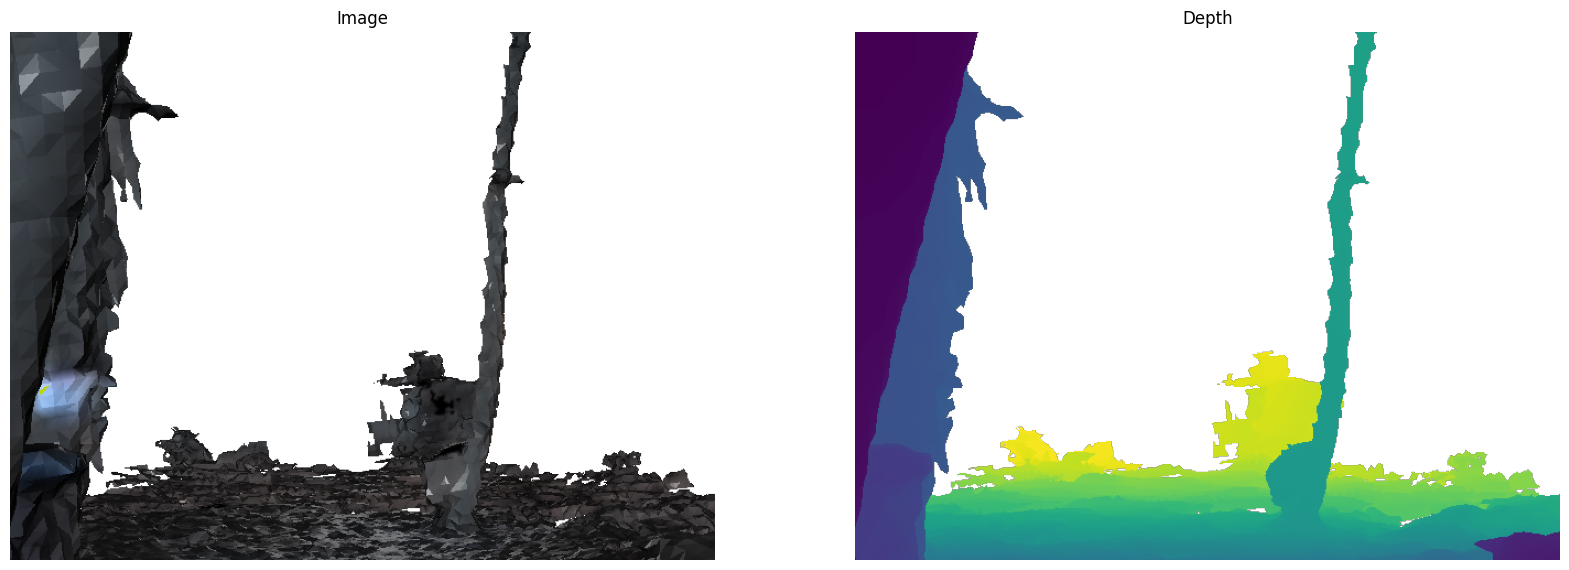

In [8]:
# Plot the image and depth
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(image)
axs[0].set_title("Image")
axs[0].axis("off")

axs[1].imshow(depth)
axs[1].set_title("Depth")
axs[1].axis("off")

### Visualize depth on mesh

In [9]:
# Use our camera and mesh environment to create an array of points on the mesh
mesh_depths = reprojection.get_depths_on_mesh(
    camera=camera, mesh=mesh_environment.mesh, smooth=True, radius=0.01
)

/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:243: RuntimeWarning: invalid value encountered in multiply
  x = (u - self.cx)[:, None] * depth / self.fx
/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:244: RuntimeWarning: invalid value encountered in multiply
  y = (v - self.cy)[:, None] * depth / self.fy
/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:248: RuntimeWarning: invalid value encountered in matmul
  points_world_hom = (self.c2w @ points_cam.T).T


Correctly mapped depths:  True


/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:120: RuntimeWarning: Mean of empty slice
  smoothed_depths[i] = np.nanmean(mesh_depths[neighbors])


Use visualization tools to view the projected depths

In [10]:
# Load the mesh as a pyvista object
pv_mesh = pv.read(mesh_fn)

# Convert to RGB via colormap
depth_rgb = cm.get_cmap("viridis")(mesh_depths)
depth_rgb[np.isnan(mesh_depths)] = [0, 0, 0, 1]

# Set as an attribute of the mesh
pv_mesh.point_data["depths"] = depth_rgb

/var/folders/2j/jdg5vjdx4x3_5tmlzl7nzygh0000gn/T/ipykernel_54724/3555225612.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  depth_rgb = cm.get_cmap("viridis")(mesh_depths)


Make a nice plot of depths visualized on the mesh

(-0.5, 2999.5, 2999.5, -0.5)

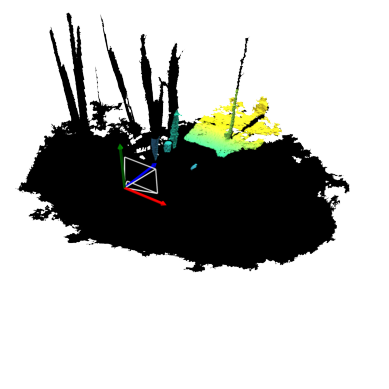

In [11]:
# Copy our camera parameters and format for pyvista
# TLB --> NEED TO FIX, IDK WHY IT INTERNALLY ALTERS PV_CAMERA
pv_camera = deepcopy(camera_params)
_ = viz.format_pyvista_camera_params(pv_camera)

# Create our camera pose
poses = [pv_camera["c2w"]]

# Create camera arguments for making frustrum
camera_kwargs = viz.CAMERA_KWARGS.copy()
camera_kwargs.update(
    {
        "line_width": 10,
        "scale": 0.025,
        "opacity": 0.9,
        "color": [0.9, 0.9, 0.9],
        "show_axes": True,
    }
)

# Select attribute to visualize
depth_mesh_kwargs = {
    "scalars": "depths",
    "rgb": True,
}

# Show the splat
plotter = viz.visualize_splat(
    pv_mesh,
    poses,
    mesh_kwargs=depth_mesh_kwargs,
    viz_kwargs=viz.VIZ_KWARGS,
    camera_kwargs=camera_kwargs,
)

# Screenshot and plot as image
mesh_image = plotter.screenshot(
    filename="mesh_depth.png",
    window_size=(3000, 3000),
    return_img=True,
    transparent_background=True,
)

plt.imshow(mesh_image)  # type: ignore
plt.axis("off")

### Map tracks between spaces

Start by loading the tracks as a dataframe

In [12]:
# Grab the top 5 track IDs
n_agents = 20
n_min_frames = 150
mesh_bounds = 375  # Y coordinate to consider points off the mesh
std_threshold = 2  # Filter tracks outside of this many stds of the moving average

# Get track counts per ID
track_counts = df_tracks.groupby("track_id").size()
track_ids = track_counts[track_counts > n_min_frames].index[:n_agents]

# Create a subset of the tracks
df_subset_tracks = df_tracks[df_tracks["track_id"].isin(track_ids)]

Get image coordinates from the bounding box

In [13]:
# Maps the bounding box to image coordinates (u, v) formatting
uv_coords = df_subset_tracks.apply(
    lambda x: reprojection.bbox_to_coords(
        x[["x1", "y1", "x2", "y2"]].values.astype(float), method="bottom_center"
    ),
    axis=1,
)
uv_coords = np.stack(uv_coords)

# Now add to the dataframe
df_subset_tracks.loc[:, ["u", "v"]] = uv_coords

Now put those coordinates in 3D and filter

In [14]:
projected_tracks = []

for track_id, df_id in tqdm(df_subset_tracks.groupby("track_id")):
    # Remove points off the mesh
    mesh_filter = df_id["y2"] > mesh_bounds
    df_id = df_id.loc[mesh_filter]

    if df_id.empty:
        continue
    df_id = df_id.reset_index(drop=True)  # Reset the index for our mapping
    df_id = df_id.sort_values("frame")  # Sort by frame number within track

    # Filter outliers and smooth tracks
    filtered_coords = reprojection.filter_coords(df_id, std_threshold=2)
    smoothed_coords = reprojection.smooth_coords(filtered_coords)

    # Update original dataframe
    df_id.loc[df_id.index, ["u", "v"]] = smoothed_coords.values
    uv_coords = df_id.loc[:, ["u", "v"]].values

    # Apply filtering and smoothing

    # TLB need to add size in here
    world_points = camera.project_to_world(uv_coords)

    # Filter out points that are not on the mesh
    mesh_contact_filter = ~np.isnan(world_points).any(1)
    world_points = world_points[mesh_contact_filter]

    # Add the points and sizes to the dataframe
    mesh_contact_idxs = np.where(mesh_contact_filter)[0]
    df_id.loc[mesh_contact_idxs, ["x", "y", "z"]] = world_points

    # Add to list of dataframes
    projected_tracks.append(df_id)

df_projected_tracks = pd.concat(projected_tracks).reset_index(drop=True)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:248: RuntimeWarning: invalid value encountered in matmul
  points_world_hom = (self.c2w @ points_cam.T).T
/Users/dima/git/collab-environment/collab_env/alignment/reprojection.py:248: RuntimeWarning: invalid value encountered in matmul
  points_world_hom = (self.c2w @ points_cam.T).T
100%|██████████| 20/20 [00:00<00:00, 451.34it/s]


#### Optional - save and upload

In [ ]:
# save as parquet - for future use

# import pyarrow as pa
# import pyarrow.parquet as pq

# pq.write_table(pa.Table.from_pandas(df_projected_tracks), session_data_dir  / f"aligned_frames/{camera_id}/{camera_id}_tracked_centroids_3d.parquet")

In [17]:
tracks_3d_fname_local =  f"aligned_frames/{camera_id}/{camera_id}_tracked_centroids_3d.csv"
df_projected_tracks.to_csv(session_data_dir / tracks_3d_fname_local)

print(f"Saved 3D tracks to {session_data_dir / tracks_3d_fname_local}")

Saved 3D tracks to 
/Users/dima/git/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/aligned_frames/rgb_1/rgb_1_trac
ked_centroids_3d.csv

In [32]:
# Load environment variables from .env file
load_dotenv()
data_key = os.environ.get("COLLAB_DATA_KEY")

print(f"Data key: {data_key}")

CURRENT_PROJECT = "COLLAB_DATA"
PROJECT_KEY = Path(os.environ.get(f"{CURRENT_PROJECT}_KEY"))  # type: ignore
PROJECT_ID = "-".join(PROJECT_KEY.stem.split("-")[:-1])

# Connect to GCS
gcs_client = GCSClient(
    project_id=PROJECT_ID,
    credentials_path=expand_path(PROJECT_KEY.as_posix(), get_project_root()),
)

gcs_client.upload_file(
    session_data_dir / tracks_3d_fname_local,
    f"{data_type}/{session}/aligned_frames/{camera_id}/"
)

Data key: ./config-local/collab-data-463313-c340ad86b28e.json

2025-08-19 00:05:57.765 | INFO     | collab_env.data.gcs_utils:__init__:35 - Using credentials from /Users/dima/git/collab-environment/config-local/collab-data-463313-c340ad86b28e.json
2025-08-19 00:05:57.768 | INFO     | collab_env.data.gcs_utils:__init__:41 - Using project collab-data-463313
2025-08-19 00:05:57.769 | INFO     | collab_env.data.gcs_utils:upload_file:180 - Uploading file /Users/dima/git/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/aligned_frames/rgb_1/rgb_1_tracked_centroids_3d.csv to fieldwork_processed/2024_02_06-session_0001/aligned_frames/rgb_1/.
2025-08-19 00:05:58.061 | INFO     | collab_env.data.gcs_utils:upload_file:182 - Uploaded file /Users/dima/git/collab-environment/data/fieldwork_processed/2024_02_06-session_0001/aligned_frames/rgb_1/rgb_1_tracked_centroids_3d.csv to fieldwork_processed/2024_02_06-session_0001/aligned_frames/rgb_1/.


#### Plot over images 

Plot over the original image, mesh view, and mesh depth 2D images

In [19]:
# Grab the original image used to align the camera
sampled_frame_dir = aligned_splat_dir / "sampled-frames"
sampled_frame_fn = list(sampled_frame_dir.glob("*.png"))[0]
image = plt.imread(sampled_frame_fn)

Setup plotting parameters

In [20]:
# Plot over the original image, mesh view, and mesh depth 2D images
cmap = "rainbow"
track_ids = df_projected_tracks["track_id"].unique()
n_tracks = len(track_ids)
colormap = plt.cm.get_cmap(cmap)  # Using rainbow for bright, distinct colors
colors = [colormap(i) for i in np.linspace(0, 1, n_tracks)]
track_colors = dict(zip(track_ids, colors))

line_kwargs = {"linestyle": "-", "linewidth": 6, "label": None, "alpha": 1}

# Create track_images directory if it doesn't exist
os.makedirs("track_images", exist_ok=True)

/var/folders/2j/jdg5vjdx4x3_5tmlzl7nzygh0000gn/T/ipykernel_54724/2447937219.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)  # Using rainbow for bright, distinct colors


Go through each image and plot

In [21]:
all_images = [camera.image, camera.depth, image]

for i, current_image in enumerate(all_images):
    # Plot tracks on the image
    track_image = viz.plot_tracks_on_image(
        df_tracks=df_projected_tracks,
        image=current_image,  # type: ignore
        colors=track_colors,
        line_kwargs=line_kwargs,
    )

    # Save each image with a unique name in track_images folder, using tight layout without borders
    track_image.savefig(
        f"track_images/track-image-{i}.png", bbox_inches="tight", pad_inches=0
    )

#### Plot tracks in 3D

(-0.5, 2999.5, 2999.5, -0.5)

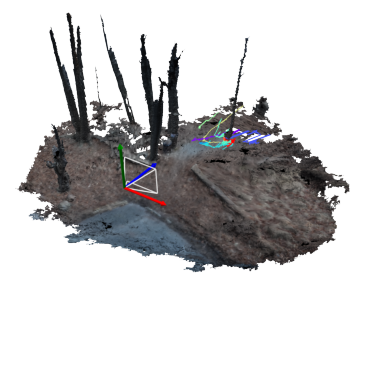

In [22]:
# Grab the pyvista camera parameters
pose = [pv_camera["c2w"]]

# Format camera frustrum
camera_kwargs = viz.CAMERA_KWARGS.copy()
camera_kwargs.update(
    {
        "line_width": 10,
        "scale": 0.025,
        "opacity": 0.9,
        "color": [0.9, 0.9, 0.9],
        "show_axes": True,
    }
)

line_kwargs = {
    "line_width": 10,
    "opacity": 1.0,
}

# Make a plotter
plotter = viz.visualize_splat(
    mesh_fn.as_posix(),
    pose,
    mesh_kwargs=viz.MESH_KWARGS,
    viz_kwargs=viz.VIZ_KWARGS,
    camera_kwargs=camera_kwargs,
)

# Add the tracks to the plotter
plotter = viz.add_tracks_to_mesh(
    df_projected_tracks,
    plotter,
    colors=track_colors,
    line_kwargs=line_kwargs,
)

mesh_image = plotter.screenshot(
    window_size=(3000, 3000),
    transparent_background=True,
    return_img=True,
)

plt.imshow(mesh_image)
plt.axis("off")